In [1]:
from collections import defaultdict

# https://github.com/Uniswap/v3-core/blob/main/contracts/libraries/TickBitmap.sol

I24_MAX = 2**23 - 1
I24_MIN = -2**23
U256_MAX = 2**256 - 1

def msb(u256):
    assert 0 < u256 <= 2**256 - 1
    x = u256
    i = 0
    if x >= 2**128:
        x >>= 128
        i += 128
    if x >= 2**64:
        x >>= 64
        i += 64
    if x >= 2**32:
        x >>= 32
        i += 32
    if x >= 2**16:
        x >>= 16
        i += 16
    if x >= 2**8:
        x >>= 8
        i += 8
    if x >= 2**4:
        x >>= 4
        i += 4
    if x >= 2**2:
        x >>= 2
        i += 2
    if x >= 2:
        # x >>= 1
        i += 1       
    return i


def lsb(u256):
    assert 0 < u256 <= 2**256 - 1
    x = u256
    i = 255
    if x & ((1 << 128) - 1) > 0:
        i -= 128
    else:
        x >>= 128
    if x & ((1 << 64) - 1) > 0:
        i -= 64
    else:
        x >>= 64
    if x & ((1 << 32) - 1) > 0:
        i -= 32
    else:
        x >>= 32
    if x & ((1 << 16) - 1) > 0:
        i -= 16
    else:
        x >>= 16
    if x & ((1 << 8) - 1) > 0:
        i -= 8
    else:
        x >>= 8
    if x & ((1 << 4) - 1) > 0:
        i -= 4
    else:
        x >>= 4
    if x & ((1 << 2) - 1) > 0:
        i -= 2
    else:
        x >>= 2
    if x & ((1 << 1) - 1) > 0:
        i -= 1    
    return i

def split(i24):
    hi = (i24 >> 8) & 0xFFFF
    lo = i24 & 0xFF
    #       u16, u8
    assert hi >= 0
    assert lo >= 0
    return (hi, lo)

def int24(val: int) -> int:
    # Mask to 24 bits
    val &= 0xFFFFFF
    # Convert to signed if the highest bit is set
    if val & 0x800000:
        val -= 0x1000000
    return val

class TickBitmap:
    @staticmethod
    def insert(ticks, i24, tick_spacing):
        assert i24 % tick_spacing == 0
        (hi, lo) = split(i24 // tick_spacing)
        ticks[hi] |= (1 << lo)

    @staticmethod    
    def remove(ticks, i24, tick_spacing):
        assert i24 % tick_spacing == 0
        (hi, lo) = split(i24 // tick_spacing)
        ticks[hi] &= (U256_MAX & ~(1 << lo))

    @staticmethod   
    def next(ticks, i24, tick_spacing, gt = True):
        assert i24 % tick_spacing == 0
        (hi, lo) = split(i24 // tick_spacing)
        if gt:
            # Search tick bit to the left
            mask = ~((1 << lo) + ((1 << lo) - 1))
            bits = ticks[hi] & mask
            if bits > 0:
                # TODO: is this correct? check tick_spacing math
                return int24((hi << 8) + lsb(bits)) * tick_spacing, True
            else:
                return int24((hi + 1) << 8) * tick_spacing, False
        else:
            # Search tick bit to the right
            mask = (1 << lo) - 1
            bits = ticks[hi] & mask
            if bits > 0:
                # TODO: is this correct?
                return int24((hi << 8) + msb(bits)) * tick_spacing, True
            else:
                return int24((hi << 8) - 1) * tick_spacing, False

class Bucket:
    def __init__(self):
        self.amt0 = 0
        self.amt1 = 0
        self.amt_out_rem = 0
        self.total = 0
        self.rem = 0
        self.amt_ins = defaultdict(int)

    def inc(self, user, amt):
        self.total += amt
        self.rem += amt
        self.amt_ins[user] += amt

    def dec(self, user, amt):
        self.total -= amt
        self.rem -= amt
        self.amt_ins[user] -= amt

    def __repr__(self):
        return f'amt0: {self.amt0} | amt1: {self.amt1} | total: {self.total} | amt_ins: {self.amt_ins}'

P1 = 1.01
    
class OrderBook:
    def __init__(self):
        tick = 0
        tick_spacing = 10
        assert tick % tick_spacing == 0
        self.tick = tick
        self.tick_spacing = tick_spacing
        # mapping u16 => u256
        self.tick_bitmap = defaultdict(int)
        self.dp = P1**tick_spacing
        self.p = P1**tick
        # bucket id => slot
        self.slots = defaultdict(int)
        # bucket id => slot => Bucket
        self.buckets = {}

    def get_bucket_id(self, tick, zero_for_one):
        return f'{tick}-{zero_for_one}'

    # delta >= 0 = amt in, amt_out >= min_amt_out
    # delta < 0 = amt out, amt_in <= max_amt_in
    def swap(self, delta, min_max, zero_for_one):
        # P1 = 1.0001
        # p = P1^tick = price of X (ETH) in terms of Y (USDC)
        # px = y

        #            Y | X
        # - tick <- 1  | 0 -> + tick

        gas = 0
        oz = not zero_for_one
        p = self.p
        t = self.tick
        rem = delta
        amt_in = 0
        amt_out = 0
        while rem != 0:
            assert gas < 100, "out of gas"
            gas += 1

            i = self.get_bucket_id(t, oz)
            s = self.slots[i]
            bucket = self.buckets.get(i, {}).get(s, None)
            
            print("swap", "tick", t, "p", p, "rem", rem, "slot", s, bucket)
            
            if bucket != None and bucket.total > 0:
                d_in = 0
                d_out = 0
                # TODO: math func to calculate max in and out
                # px = y
                # rem >= 0 = amt_in_rem
                # rem < 0 = amt_out_rem 
                if zero_for_one:
                    # y <- x
                    max_out = bucket.amt1
                    max_in = max_out / p
                    if rem >= 0:
                        # rem = x, in = x, out = y
                        d_in = min(max_in, rem)
                        d_out = min(max_out, rem * p)
                    else:
                        # rem = y, in = x, out = y
                        d_in = min(max_in, -rem / p)
                        d_out = min(max_out, -rem)
                    bucket.amt0 += d_in
                    bucket.amt1 -= d_out
                    assert bucket.amt1 >= 0
                else:
                    # y -> x
                    max_out = bucket.amt0
                    max_in = max_out * p
                    if rem >= 0:
                        # rem = y, in = y, out = x
                        d_in = min(max_in, rem)
                        d_out = min(max_out, rem / p)
                    else:
                        # rem = x, in = y, out = x
                        d_in = min(max_in, -rem * p)
                        d_out = min(max_out, -rem)
                    bucket.amt0 -= d_out
                    bucket.amt1 += d_in
                    assert bucket.amt0 >= 0

                amt_in += d_in
                amt_out += d_out
                if rem >= 0:
                    rem -= d_in
                    assert rem >= 0, f'rem: {rem}'
                else:
                    rem += d_out
                    assert rem <= 0, f'rem: {rem}'

                if (zero_for_one and bucket.amt1 == 0) or (not zero_for_one and bucket.amt0 == 0):
                    self.slots[i] += 1
                    TickBitmap.remove(self.tick_bitmap, t, self.tick_spacing)
                    if zero_for_one:
                        assert bucket.amt0 > 0
                        assert bucket.amt1 == 0
                        bucket.amt_out_rem = bucket.amt0
                    else:
                        assert bucket.amt0 == 0
                        assert bucket.amt1 > 0
                        bucket.amt_out_rem = bucket.amt1
            if rem != 0:
                # TODO: optimization on initialized
                (next_tick, initialized) = TickBitmap.next(self.tick_bitmap, t, self.tick_spacing, not zero_for_one)
                t = next_tick
                # TODO: optimize math - use rpow and p = p * p1**(tick - next_tick)?
                p = P1**next_tick   
        self.p = p
        self.tick = t

        if delta >= 0:
            assert amt_out >= min_max, "out < min"
        else:
            assert amt_in <= min_max, "in > max"

        return (amt_in, amt_out)
    
    def inc(self, tick, zero_for_one, amt, **kwargs):
        msg_sender = kwargs["msg_sender"]

        assert tick % self.tick_spacing == 0
        if zero_for_one:
            assert self.tick < tick
        else:
            assert tick < self.tick

        TickBitmap.insert(self.tick_bitmap, tick, self.tick_spacing)

        i = self.get_bucket_id(tick, zero_for_one)
        s = self.slots[i]
        if self.buckets.get(i) is None:
            self.buckets[i] = {}
        if self.buckets[i].get(s) is None:
            self.buckets[i][s] = Bucket()

        bucket = self.buckets[i][s]
        bucket.inc(msg_sender, amt)
        if zero_for_one:
            bucket.amt0 += amt
        else:
            bucket.amt1 += amt

    def dec(self, tick, zero_for_one, amt, **kwargs):
        msg_sender = kwargs["msg_sender"]

        i = self.get_bucket_id(tick, zero_for_one)
        s = self.slots[i]
        bucket = self.buckets[i][s]

        assert amt <= bucket.amt_ins[msg_sender]

        amt0_out = bucket.amt0 * amt / bucket.total
        amt1_out = bucket.amt1 * amt / bucket.total

        bucket.amt0 -= amt0_out
        bucket.amt1 -= amt1_out
        # TODO: correct math? need to do vault math?
        bucket.dec(msg_sender, amt)

        # Dust
        if bucket.total == 0:
            TickBitmap.remove(self.tick_bitmap, tick, self.tick_spacing)
            amt0_out += bucket.amt0
            amt1_out += bucket.amt1
            del self.buckets[i][s]

        return (amt0_out, amt1_out)

    def take(self, slot, tick, zero_for_one, **kwargs):
        msg_sender = kwargs["msg_sender"]

        i = self.get_bucket_id(tick, zero_for_one)
        assert slot < self.slots[i]
        bucket = self.buckets[i][slot]

        total_out = 0
        if zero_for_one:
            assert bucket.amt0 == 0
            assert bucket.amt1 > 0
            total_out = bucket.amt1
        else:
            assert bucket.amt0 > 0
            assert bucket.amt1 == 0
            total_out = bucket.amt0

        amt_in = bucket.amt_ins[msg_sender]
        amt_out = total_out * amt_in / bucket.total

        bucket.amt_ins[msg_sender] = 0
        bucket.rem -= amt_in
        bucket.amt_out_rem -= amt_out

        # Dust
        if bucket.rem == 0:
            amt_out += bucket.amt_out_rem
            del self.buckets[i][slot]
        
        # TODO: check amt_out approx = P**tick * a_in?
        return amt_out


In [6]:
book = OrderBook()
book.inc(10, True, 100, msg_sender = "bob")
book.inc(10, True, 100, msg_sender = "alice")
book.inc(100, True, 110, msg_sender = "charlie")

(amt_in, amt_out) = book.swap(-210, 300, False)
print("in", amt_in, "out", amt_out)

for (t, sb) in book.buckets.items():
    print(t)
    for (s, b) in sb.items():
        print(s, b)

book.take(0, 10, True, msg_sender = "alice")

swap tick 0 p 1.0 rem -210 slot 0 None
swap tick 10 p 1.1046221254112045 rem -210 slot 0 amt0: 200 | amt1: 0 | total: 200 | amt_ins: defaultdict(<class 'int'>, {'bob': 100, 'alice': 100})
swap tick 100 p 2.7048138294215285 rem -10 slot 0 amt0: 110 | amt1: 0 | total: 110 | amt_ins: defaultdict(<class 'int'>, {'charlie': 110})
in 247.97256337645618 out 210
10-True
0 amt0: 0 | amt1: 220.9244250822409 | total: 200 | amt_ins: defaultdict(<class 'int'>, {'bob': 100, 'alice': 100})
100-True
0 amt0: 100 | amt1: 27.048138294215285 | total: 110 | amt_ins: defaultdict(<class 'int'>, {'charlie': 110})


110.46221254112044

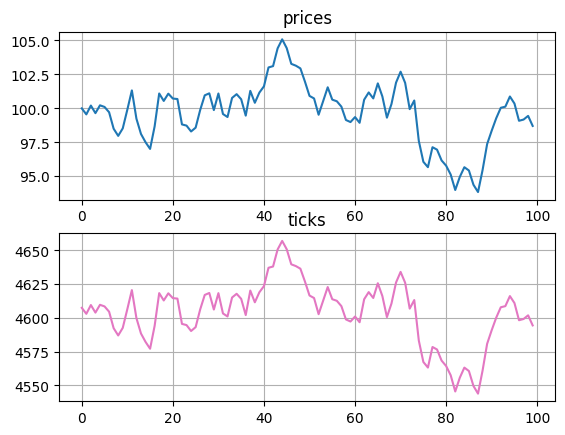

In [55]:
import numpy as np
import math
import matplotlib.pyplot as plt

N = 100
# Initial price
B = 1.001
p0 = 100
MIN_PRICE = 0.00001
# Volatility
v = 1
delta_prices = np.random.normal(0, v, N)

# Prices
p = p0
prices = []
ticks = []
for dp in delta_prices:
    t = math.log(p, B)
    ticks.append(t)
    prices.append(p)
    p = max(p + dp, MIN_PRICE)

# Create 2 subplots: 1 row, 2 columns
# (rows, cols, index)
plt.subplot(2, 1, 1)
plt.title("prices")
plt.plot(prices)
plt.grid()

plt.subplot(2, 1, 2)
plt.title("ticks")
plt.plot(ticks, color="tab:pink")
plt.grid()

plt.show()

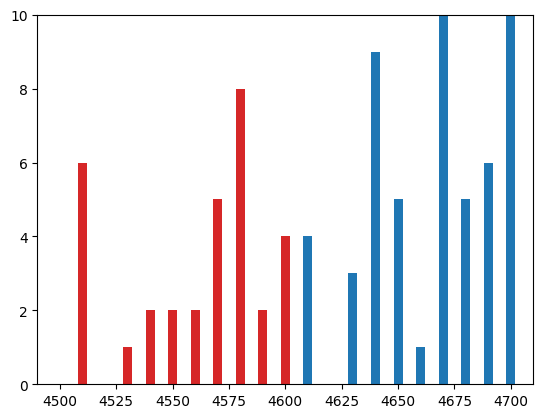

In [56]:
import math
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Y_MAX = 10
tick_spacing = 10
min_tick = -100
max_tick = 100
t0 = 4600
tick = t0

# Data
x_ticks = nums = [t0 + t for t in range(min_tick, max_tick + 1, tick_spacing)]

def generate_vals(tick):
    vals = []
    for t in x_ticks:
        if tick < t:
            y = random.randint(0, Y_MAX)
            vals.append((0, y))
        elif t < tick:
            x = random.randint(0, Y_MAX)
            vals.append((x, 0))
        else:
            x = random.randint(0, Y_MAX // 2)
            y = random.randint(0, Y_MAX // 2)
            vals.append((x, y))
    return vals

# Plot
fig, ax = plt.subplots()

ax.set_xlim(t0 + min_tick - tick_spacing, t0 + max_tick + tick_spacing)
ax.set_ylim(0, Y_MAX)

bars_red = ax.bar(x_ticks, [0]*len(x_ticks), color="tab:red", width=4)
bars_blue = ax.bar(x_ticks, [0]*len(x_ticks), color="tab:blue", width=4, bottom=[0]*len(x_ticks))

def update(frame):
    # tick = ticks[frame]
    vals = generate_vals(tick)
    
    for i, (x, y) in enumerate(vals):
        bars_red[i].set_height(x)
        bars_blue[i].set_height(y)
        bars_blue[i].set_y(x)
        
    return bars_red + bars_blue

ani = FuncAnimation(fig, update, frames=range(0, 50, 1), interval=500, blit=False)

# For JupyterLab
HTML(ani.to_jshtml())